In [1]:
from commonfunctions import *

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier  # MLP is an NN
from sklearn import svm
import numpy as np
import argparse
import cv2
import os
import random
from sklearn.model_selection import train_test_split
import pytesseract

import skimage
import skimage.io as io
import matplotlib.pyplot as plt
from skimage import filters, feature
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle
from scipy.ndimage import median_filter
import cv2 as cv

# Convolution:
from scipy.signal import convolve2d
from scipy import fftpack
import math

In [3]:

from typing import List


def get_largest_contour_list(contour_lists: List[List]) -> List[List]:
    """
    Returns a list containing the contour list with the largest number of contours.
    
    Parameters:
    - contour_lists (List[List]): A list containing multiple lists of contours.

    Returns:
    - List[List]: A list containing the contour list with the maximum number of contours.
    """
    # Handle empty input
    if not contour_lists:
        return []
    if not contour_lists:
        raise ValueError("Input must contain at least one list of contours.")
    
    # Find the list with the maximum number of contours
    largest_contour_list = max(contour_lists, key=len)
    
    # Return as a list containing only the largest contour list
    return [largest_contour_list]

# Function for bright RGB image enhancement
def enhance_bright_image_rgb(image):
    enhanced_image = image.copy()
    for channel in range(3):  # Process R, G, B channels
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                pixel_value = image[y, x, channel]
                if 200 <= pixel_value <= 230:
                    # Scale pixel value between 240 and 255
                    enhanced_image[y, x, channel] = 240 + (pixel_value - 200) * (255 - 240) // (230 - 200)
                elif pixel_value > 230:
                    # Keep values above 230 as they are
                    enhanced_image[y, x, channel] = 255
                else:
                    # Keep values below 200 unchanged
                    enhanced_image[y, x, channel] = pixel_value
    return enhanced_image

# Function for dark RGB image enhancement
def enhance_dark_image_rgb(image):
    enhanced_image = image.copy()
    for channel in range(3):  # Process R, G, B channels
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                pixel_value = image[y, x, channel]
                if 130 <= pixel_value <= 200:
                    # Scale pixel value between 230 and 255
                    enhanced_image[y, x, channel] = 230 + (pixel_value - 130) * (255 - 230) // (200 - 130)
                elif pixel_value > 200:
                    # Keep values above 200 as they are
                    enhanced_image[y, x, channel] = 255
                else:
                    # Keep values below 130 unchanged
                    enhanced_image[y, x, channel] = pixel_value
    return enhanced_image

def enhance_very_dark_image_rgb(image):
    enhanced_image = image.copy()
    for channel in range(3):  # Process R, G, B channels
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                pixel_value = image[y, x, channel]
                if 90 <= pixel_value <= 150:
                    # Scale pixel value between 230 and 250
                    enhanced_image[y, x, channel] = 230 + (pixel_value - 90) * (250 - 230) // (150 - 90)
                elif pixel_value > 150:
                    # Keep values above 150 as they are
                    enhanced_image[y, x, channel] = pixel_value
                else:
                    # Keep values below 90 unchanged
                    enhanced_image[y, x, channel] = pixel_value
    return enhanced_image

def enhance_bright_image(image):
    enhanced_image = image.copy()
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            pixel_value = image[y, x]
            if 200 <= pixel_value <= 230:
                # Scale pixel value between 240 and 255
                enhanced_image[y, x] = 240 + (pixel_value - 200) * (255 - 240) // (230 - 200)
            elif pixel_value > 230:
                # Keep values above 230 as they are
                enhanced_image[y, x] = 255
            else:
                # Keep values below 200 unchanged
                enhanced_image[y, x] = pixel_value
    return enhanced_image

def enhance_dark_image(image):
    enhanced_image = image.copy()
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            pixel_value = image[y, x]
            if 130 <= pixel_value <= 200:
                # Scale pixel value between 230 and 255
                enhanced_image[y, x] = 230 + (pixel_value - 130) * (255 - 230) // (200 - 130)
            elif pixel_value > 200:
                # Keep values above 200 as they are
                enhanced_image[y, x] = 255
            else:
                # Keep values below 130 unchanged
                enhanced_image[y, x] = pixel_value
    return enhanced_image

def calculate_percentage_of_ones(binary_img):
    

    # Calculate the number of 1's
    num_ones = np.count_nonzero(binary_img)

    # Calculate the total number of pixels
    total_pixels = binary_img.size

    # Calculate the percentage of 1's
    percentage_of_ones = (num_ones / total_pixels) * 100

    return percentage_of_ones



# Function for enhancing both dark and bright RGB image enhancement
def enhance_image_rgb(image):
    enhanced_image = image.copy()

    for channel in range(3):  # Process R, G, B channels
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                pixel_value = image[y, x, channel]
                
                # Enhance dark to very dark pixel values (90 to 200)
                if 90 <= pixel_value <= 200:
                    if pixel_value <= 130:
                        # Scale very dark pixels between 90 and 150 to 230 to 250
                        enhanced_image[y, x, channel] = 230 + (pixel_value - 90) * (250 - 230) // (150 - 90)
                    elif pixel_value <= 200:
                        # Scale dark pixels between 130 and 200 to 230 to 255
                        enhanced_image[y, x, channel] = 230 + (pixel_value - 130) * (255 - 230) // (200 - 130)
                # Enhance bright pixels (200 to 230 range)
                elif 200 <= pixel_value <= 230:
                    # Scale bright pixels between 200 and 230 to 240 to 255
                    enhanced_image[y, x, channel] = 240 + (pixel_value - 200) * (255 - 240) // (230 - 200)
                elif pixel_value > 230:
                    # Keep values above 230 as they are (already maximized)
                    enhanced_image[y, x, channel] = 255
                else:
                    # Keep values below 90 unchanged (dark/black areas)
                    enhanced_image[y, x, channel] = pixel_value

    return enhanced_image

def enhance_image(image):
    enhanced_image = image.copy()

    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            pixel_value = image[y, x]
                
            # Enhance dark to very dark pixel values (90 to 200)
            if 90 <= pixel_value <= 200:
                if pixel_value <= 130:
                    # Scale very dark pixels between 90 and 150 to 230 to 250
                    enhanced_image[y, x] = 230 + (pixel_value - 90) * (250 - 230) // (150 - 90)
                elif pixel_value <= 200:
                    # Scale dark pixels between 130 and 200 to 230 to 255
                    enhanced_image[y, x] = 230 + (pixel_value - 130) * (255 - 230) // (200 - 130)
            # Enhance bright pixels (200 to 230 range)
            elif 200 <= pixel_value <= 230:
                # Scale bright pixels between 200 and 230 to 240 to 255
                enhanced_image[y, x] = 240 + (pixel_value - 200) * (255 - 240) // (230 - 200)
            elif pixel_value > 230:
                # Keep values above 230 as they are (already maximized)
                enhanced_image[y, x] = 255
            else:
                # Keep values below 90 unchanged (dark/black areas)
                enhanced_image[y, x] = pixel_value

    return enhanced_image

from scipy.signal import find_peaks, peak_widths
def has_salt_and_pepper_noise(image):
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Flatten the image for histogram analysis
    flattened_image = image.flatten()
    hist, bins = np.histogram(flattened_image, bins=256, range=(0, 255))

    # Detect peaks
    peaks, properties = find_peaks(hist, prominence=0.1 * np.max(hist))  # Prominent peaks
    widths = peak_widths(hist, peaks, rel_height=0.5)[0]  # Measure widths at half prominence

    # Filter peaks that are narrow (spikes)
    spike_indices = [i for i, width in enumerate(widths) if width <= 2]  # Adjust width threshold
    spikes = peaks[spike_indices]

    # Count spikes
    num_spikes = len(spikes)
    print(f"Detected Impulses (Spikes): {num_spikes}")

    # Decision based on spike count
    if num_spikes >= 5:  # Adjust threshold as needed
        return True
    return False


# checks whether the red channel is dominating 
def detect_dominant_red_channel(image, red_threshold=1.3):
    # Ensure the image has 3 channels (RGB)
    if image.shape[-1] != 3:
        raise ValueError("Image must be an RGB image")

    # Split the image into R, G, B channels
    R = image[:, :, 0]
    G = image[:, :, 1]
    B = image[:, :, 2]

    # Calculate the mean intensity of each channel
    mean_R = np.mean(R)
    mean_G = np.mean(G)
    mean_B = np.mean(B)

    print(f"Mean R: {mean_R:.2f}, Mean G: {mean_G:.2f}, Mean B: {mean_B:.2f}")

    # Check if the red channel is dominant compared to green and blue
    if mean_R > red_threshold * mean_G and mean_R > red_threshold * mean_B:
        print("The red channel is dominant.")
        return True
    else:
        print("The red channel is not dominant.")
        return False
    
# function used to equalize the red channel
def equalizeredchannel(img):
    img = img.astype(np.float32)
    
    red_channel = img[:, :, 0]
    green_channel = img[:, :, 1]
    blue_channel = img[:, :, 2]

    original_red = np.clip(red_channel / 1.5, 0, 255).astype(np.uint8)
    
    equalized_img = np.stack((original_red, green_channel, blue_channel), axis=2).astype(np.uint8)
    return equalized_img
    
# checks if the image contains additive noise or not
def detect_gaussian_noise(image, threshold_std=10):
    #  Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    else:
        gray = image

    # Smooth the image using Gaussian Blur
    blurred = cv.GaussianBlur(gray, (5, 5), 1.0)

    # Subtract the blurred image from the original image to isolate noise
    noise = gray.astype(np.float32) - blurred.astype(np.float32)

    # Calculate the standard deviation of the noise
    noise_std = np.std(noise)
    print(f"Noise Standard Deviation: {noise_std:.2f}")

    # Threshold to classify noise
    if noise_std > threshold_std:
        print("Gaussian noise detected.")
        return True
    else:
        print("No significant Gaussian noise detected.")
        return False

def apply_mask(image, mask):
    """
    Apply a binary mask to an image.
    
    Parameters:
    - image: The input image (numpy array).
    - mask: The binary mask (numpy array), where `1` indicates that the pixel in the image should be kept, 
    and `0` means the pixel should be masked out.
    
    Returns:
    - result: The image after the mask has been applied.
    """
    # Ensure the mask is binary (0 or 1) and has the same shape as the image
    mask = mask.astype(np.uint8)  # Convert mask to uint8 for safety
    if mask.shape != image.shape:
        raise ValueError("The image and mask must have the same shape")

    # Apply the mask to the image: element-wise multiplication
    result = cv.bitwise_and(image, mask)
    
    return result

In [4]:
# def process_image(imageIn):
#     # 1- Get the required RGB color (Using a color picker)

#     img = imageIn

#     if img.shape[0] < 800 and img.shape[1] < 600:
#         img = cv.resize(img, (800, 600))
#     imgg = img
#     if has_salt_and_pepper_noise(img):
#         print("Salt and pepper noise detected!")
#         img = median_filter(img, size = 3)
#     else:
#         print("No salt and pepper noise detected.")

#     # Assuming img is your input image
#     if img.dtype == np.float64:
#         # Convert the image to uint8
#         img = img.astype(np.uint8)

#         # Or use .astype(np.uint8) directly if the values are already in [0, 255]

#     img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
#     image = np.copy(img)
#     if img.shape[2] == 4:
#         image = rgba2rgb(image)
#     if detect_dominant_red_channel(image):
#         print("Excessive red channel detected.")
#         img = equalizeredchannel(img)
#     else:
#         print("No excessive red channel detected.")

#     if detect_gaussian_noise(img, threshold_std=15):
#         print("Image contains additive Gaussian noise.")
#         img = gaussian(img, sigma = 1.3)
#     else:
#         print("Image does not contain significant Gaussian noise.")

#     if len(img.shape) == 3:
#         height , width , channel = img.shape
#     elif len(img.shape) == 2:
#         height , width  = img.shape

#     gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

#     img = enhance_image_rgb(img)

#     TragetColor = np.array([240/255,240/255,240/255]) 

#     # 2- Read image

#     img = img.astype(float) / 255

#     # 3- Extract R, G, and B channels (as float)
#     RedChannel = img[:,:,0]
#     GreenChannel = img[:,:,1]
#     BlueChannel = img[:,:,2]

#     # 4- Calculate differences FOR EACH CHANNEL (between the image and the required pixel value)
#     DiffRed = np.abs(RedChannel - TragetColor[0])
#     DiffGreen = np.abs(GreenChannel - TragetColor[1])
#     DiffBlue = np.abs(BlueChannel - TragetColor[2])

#     # 5- Calculate overall distance from the given RGB color (use Euclidean distance)
#     Distance = np.sqrt(DiffRed**2 + DiffGreen**2 + DiffBlue**2)

#     # 6- Create a mask by thresholding the differences
#     Threshold = 0.1
#     Mask = np.where(Distance < Threshold , True,False)

#     # 7- Replace the pixels of the mask with the new color (R=230, G=90, B=40)
#     ReplacedColor = np.array([230/255, 90/255, 40/255])

#     # Create a copy of the image to apply the changes
#     modified_img = np.copy(img)

#     struct_elem = np.ones((2, 3))
#     img_dilated1 = binary_dilation(Mask, struct_elem).astype(img.dtype)

#     struct_elem = np.ones((12, 4))
#     img_closed = binary_erosion(img_dilated1, struct_elem).astype(img.dtype)

#     struct_elem = np.ones((70, 180))
#     img_dilated = binary_dilation(img_closed, struct_elem).astype(img.dtype)

#     percentageOfOnes   = calculate_percentage_of_ones(img_dilated )
#     # Apply the new color where the mask is True
#     modified_img[Mask] = ReplacedColor

#     # Convert to binary image using a simple threshold
#     ret, binary_img = cv.threshold(gray, 210, 255, cv.THRESH_BINARY)

#     struct_elem = np.ones((50,50))
#     img_Dilatedd_adaptive = binary_dilation(binary_img, struct_elem).astype(img.dtype)

#     # Optionally, visualize contours on the labeled image
#     contours, _ = cv.findContours(binary_img, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)

#     masked_img_dilated = np.zeros_like(gray)  # Create an empty array with the same shape as gray
#     masked_img_dilated[img_dilated >= 1] = gray[img_dilated >= 1]  # Retain the grayscale values where mask is 255

#     masked_img_dilated_adaptivaly = np.zeros_like(gray)  # Create an empty array with the same shape as gray
#     masked_img_dilated_adaptivaly[img_Dilatedd_adaptive >= 1] = gray[img_Dilatedd_adaptive >= 1]  # Retain the grayscale values where mask is 255


#     if percentageOfOnes >= 90 and percentageOfOnes <91:
#         output_img = masked_img_dilated_adaptivaly
#     elif percentageOfOnes >=99:
#         output_img = masked_img_dilated_adaptivaly
#     else:
#         output_img = masked_img_dilated

#     blurred_img = cv.GaussianBlur(output_img , ksize=(5,5) , sigmaX=0)
#     thresholded_img = cv.adaptiveThreshold(blurred_img , maxValue=255.0 , adaptiveMethod=cv.ADAPTIVE_THRESH_MEAN_C
#                                             ,thresholdType=cv.THRESH_BINARY_INV, blockSize=19,C=9)


#     contours ,_ = cv.findContours(thresholded_img , mode = cv.RETR_LIST , method=cv.CHAIN_APPROX_SIMPLE)
#     temp_result = np.zeros((height,width,channel),dtype=np.uint8)
#     cv.drawContours(temp_result , contours=contours , contourIdx=-1 , color=(255,255,255))

#     max_diag_multiplyer = 4.1
#     max_angle_diff = 25.0
#     max_area_diff = 1.47
#     max_width_diff = 1.5
#     max_height_diff = 0.18
#     min_n_matched = 4

#     def find_chars(contours_list):
#         matched_result_idx = []

#         for d1 in contours_list:
#             matched_contour_idx = []
#             for d2 in contours_list:
#                 if d1['idx'] == d2['idx']:
#                     continue

#                 dx = abs(d1['cx'] - d2['cx'])
#                 dy = abs(d1['cy'] - d2['cy'])

#                 diagonal_length = np.sqrt(d1['w']**2 + d1['h']**2)
#                 distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))

#                 angle_diff = 90 if dx == 0 else np.degrees(np.arctan(dy / dx))
                
#                 area_diff = abs((d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h']))
#                 width_diff = abs((d1['w'] - d2['w']) / d1['w'])
#                 height_diff = abs((d1['h'] - d2['h']) / d1['h'])

#                 if distance < diagonal_length * max_diag_multiplyer and angle_diff < max_angle_diff \
#                     and area_diff < max_area_diff and width_diff < max_width_diff and height_diff < max_height_diff:
#                     matched_contour_idx.append(d2['idx'])

#             if len(matched_contour_idx) < min_n_matched:
#                 continue

#             matched_result_idx.append([d1['idx']] + matched_contour_idx)

#             unmatched_contour_idx = [d4['idx'] for d4 in contours_list if d4['idx'] not in matched_contour_idx]

#             if not unmatched_contour_idx:
#                 break

#             unmatched_contour = np.array([d for d in contours_list if d['idx'] in unmatched_contour_idx])
#             recursive_contour_list = find_chars(unmatched_contour)

#             for idx in recursive_contour_list:
#                 matched_result_idx.append(idx)

#             break

#         return matched_result_idx

#     plate_width_padding = 0.6
#     plate_height_padding = 1.5
#     min_plate_ratio =1
#     max_plate_ratio = 2


#     plate_imgs = []
#     plate_infos = []

#     for i , matched_chars in enumerate(matched_result):
#         sorted_chars = sorted(matched_chars , key=lambda x : x['cx'])

#         plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) /2
#         plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) /2

#         plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['w'] ) * plate_width_padding

#         sum_height = 0
#         cropped_imgs = []
#         for d in sorted_chars:
#             sum_height += d['h']


#         plate_height = int(sum_height / len(sorted_chars) * plate_height_padding)

#         triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
#         triangle_hypotenus = np.linalg.norm(
#             np.array([sorted_chars[0]['cx'] , sorted_chars[0]['cy']]) -
#             np.array([sorted_chars[-1]['cx'] , sorted_chars[-1]['cy']])
#         )

#         angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))

#         rotation_matrix = cv.getRotationMatrix2D(center=(plate_cx , plate_cy) , angle=angle , scale=1.0)

#         img_rotated = cv.warpAffine(thresholded_img , M=rotation_matrix , dsize=(width, height))

#         img_cropped = cv.getRectSubPix(
#             img_rotated,
#             patchSize=(int(plate_width) , int(plate_height)),
#             center = (int(plate_cx) , int(plate_cy))
#         )

#         if img_cropped.shape[1] / img_cropped.shape[0] < min_plate_ratio or min_plate_ratio < img_cropped.shape[1] / img_cropped.shape[0] <  max_plate_ratio:
#             continue


#         plate_imgs.append(img_cropped)
        
#         plate_infos.append({
#             'x':int(plate_cx - plate_width /2),
#             'y':int(plate_cy - plate_height /2),
#             'w':int(plate_width),
#             'h':int(plate_height)
#         })

#     plate_width_padding = 0.6
#     plate_height_padding = 1.5
#     min_plate_ratio =1
#     max_plate_ratio = 2


#     plate_imgs = []
#     plate_infos = []

#     for i , matched_chars in enumerate(matched_result):
#         sorted_chars = sorted(matched_chars , key=lambda x : x['cx'])

#         plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) /2
#         plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) /2

#         plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['w'] ) * plate_width_padding

#         sum_height = 0
#         cropped_imgs = []
#         for d in sorted_chars:
#             sum_height += d['h']


#         plate_height = int(sum_height / len(sorted_chars) * plate_height_padding)

#         triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
#         triangle_hypotenus = np.linalg.norm(
#             np.array([sorted_chars[0]['cx'] , sorted_chars[0]['cy']]) -
#             np.array([sorted_chars[-1]['cx'] , sorted_chars[-1]['cy']])
#         )

#         angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))

#         rotation_matrix = cv.getRotationMatrix2D(center=(plate_cx , plate_cy) , angle=angle , scale=1.0)

#         img_rotated = cv.warpAffine(thresholded_img , M=rotation_matrix , dsize=(width, height))

#         img_cropped = cv.getRectSubPix(
#             img_rotated,
#             patchSize=(int(plate_width) , int(plate_height)),
#             center = (int(plate_cx) , int(plate_cy))
#         )

#         if img_cropped.shape[1] / img_cropped.shape[0] < min_plate_ratio or min_plate_ratio < img_cropped.shape[1] / img_cropped.shape[0] <  max_plate_ratio:
#             continue


#         plate_imgs.append(img_cropped)
        
#         plate_infos.append({
#             'x':int(plate_cx - plate_width /2),
#             'y':int(plate_cy - plate_height /2),
#             'w':int(plate_width),
#             'h':int(plate_height)
#         })


#     cropped = img_cropped

#     contours ,_ = cv.findContours(img_cropped , mode = cv.RETR_LIST , method=cv.CHAIN_APPROX_SIMPLE)
#     temp_result = np.zeros((img_cropped.shape[0],img_cropped.shape[1]),dtype=np.uint8)
#     cv.drawContours(temp_result , contours=contours , contourIdx=-1 , color=(255,255,255))

#     temp_result = np.zeros((img_cropped.shape[0],img_cropped.shape[1]),dtype=np.uint8)
#     contours_dict=[]

#     for contour in contours:
#         x,y,w,h = cv.boundingRect(contour)
#         cv.rectangle(temp_result , pt1=(x,y),pt2=(x+w,y+h) , color=(255,255,255) , thickness=1)
#         #insert the rectangles into the dict
#         contours_dict.append({'contour' : contour , 'x':x,'y':y,'w':w,'h':h ,'cx':x+(w/2),'cy': y+(h/2)})

#     min_area = 149
#     max_area = 2000
#     min_width , min_height = 1,5
#     min_ratio , max_ratio = 0.25 , 1.62

#     possible_contours = []

#     cnt = 0

#     for d in contours_dict:
#         area = d['w'] * d['h']
#         ratio = d['w'] / d['h']

#         if min_area<area <max_area  and d['w'] > min_width and d['h'] > min_height and min_ratio < ratio <max_ratio:
#             d['idx'] = cnt
#             cnt +=1
#             possible_contours.append(d)

#     temp_result = np.zeros((img_cropped.shape[0],img_cropped.shape[1]),dtype=np.uint8)
#     for d in possible_contours:
#         cv.rectangle(temp_result , pt1=(d['x'],d['y']) , pt2=(d['x']+d['w'] , d['y']+d['h']) , color=(255,255,255) , thickness=2)

#     max_diag_multiplyer = 8
#     max_angle_diff = 25.0
#     max_area_diff = 10
#     max_width_diff = 5
#     max_height_diff = 0.2  #changed to 0.3 to let image 23 to work and also 31
#     min_n_matched = 2
#     def find_chars(contours_list):
#         matched_result_idx = []

#         for d1 in contours_list:
#             matched_contour_idx = []
#             for d2 in contours_list:
#                 if d1['idx'] == d2['idx']:
#                     continue

#                 dx = abs(d1['cx'] - d2['cx'])
#                 dy = abs(d1['cy'] - d2['cy'])

#                 diagonal_length = np.sqrt(d1['w']**2 + d1['h']**2)
#                 distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))

#                 angle_diff = 90 if dx == 0 else np.degrees(np.arctan(dy / dx))
                
#                 area_diff = abs((d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h']))
#                 width_diff = abs((d1['w'] - d2['w']) / d1['w'])
#                 height_diff = abs((d1['h'] - d2['h']) / d1['h'])

#                 if distance < diagonal_length * max_diag_multiplyer and angle_diff < max_angle_diff \
#                     and area_diff < max_area_diff and width_diff < max_width_diff and height_diff < max_height_diff:
#                     matched_contour_idx.append(d2['idx'])

#             if len(matched_contour_idx) < min_n_matched:
#                 continue

#             matched_result_idx.append([d1['idx']] + matched_contour_idx)

#             unmatched_contour_idx = [d4['idx'] for d4 in contours_list if d4['idx'] not in matched_contour_idx]

#             if not unmatched_contour_idx:
#                 break

#             unmatched_contour = np.array([d for d in contours_list if d['idx'] in unmatched_contour_idx])
#             recursive_contour_list = find_chars(unmatched_contour)

#             for idx in recursive_contour_list:
#                 matched_result_idx.append(idx)

#             break

#         return matched_result_idx



#     result_idx = find_chars(possible_contours)

#     matched_resultx = []

#     for idx_list in result_idx:
#         matched_resultx.append(np.take(possible_contours , idx_list))



#     temp_resultx = np.zeros((img_cropped.shape[0],img_cropped.shape[1]),dtype=np.uint8)
#     for r in matched_resultx:
#         for d in r:
            
#             cv.rectangle(temp_resultx , pt1=(d['x'],d['y']) , pt2=(d['x']+d['w'] , d['y']+d['h']) , color=(255,255,255) , thickness=2)
            
#     temp_result = np.zeros((img_cropped.shape[0],img_cropped.shape[1]),dtype=np.uint8)

#     matched_result = get_largest_contour_list(matched_resultx)

#     for r in matched_result:
#         for d in r:
            
#             cv.rectangle(temp_result , pt1=(d['x'],d['y']) , pt2=(d['x']+d['w'] , d['y']+d['h']) , color=(255,255,255) , thickness=cv.FILLED)

#     return apply_mask(cropped , temp_result)

In [5]:
def extract_hog_features(img):
    target_img_size = (32, 32) # fix image size because classification algorithms THAT WE WILL USE HERE expect that
    img = cv2.resize(img, target_img_size)
    win_size = (32, 32)
    cell_size = (4, 4)
    block_size_in_cells = (2, 2)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()

In [6]:
def load_dataset():

    path_to_dataset = r'digits_dataset'

    features = []
    labels = []

    # Iterate through subfolders (assume folder name is the label)
    for label_folder in os.listdir(path_to_dataset):
        label_path = os.path.join(path_to_dataset, label_folder)
        
        # Ensure it's a directory (skip files)
        if not os.path.isdir(label_path):
            continue
        
        # Extract label from the folder name
        label = label_folder
        
        # Iterate through the images in the folder
        for img_filename in os.listdir(label_path):
            img_path = os.path.join(label_path, img_filename)
            
            # Read image
            img = cv2.imread(img_path)
            
            # Extract features (e.g., HOG features)
            features.append(extract_hog_features(img))
            
            # Append the label
            labels.append(label)
            
            # Show an update every 1,000 images
            if len(features) % 1000 == 0:
                print(f"[INFO] Processed {len(features)} images so far.")

    return features, labels


In [7]:
classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=7)
}

def run_experiment():
    # We are going to fix the random seed to make our experiments reproducible 
    # since some algorithms use pseudorandom generators
    random_seed = 42  
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    # Load dataset with extracted features
    print('Loading dataset. This will take time ...')
    features, labels = load_dataset()
    print('Finished loading dataset.')
    
    # Since we don't want to know the performance of our classifier on images it has seen before
    # we are going to withhold some images that we will test the classifier on after training 
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels, test_size=0.2, random_state=random_seed)
    
    for model_name, model in classifiers.items():
        print('############## Training', model_name, "##############")
        # Train the model only on the training features
        model.fit(train_features, train_labels)
        
        # Test the model on images it hasn't seen before
        accuracy = model.score(test_features, test_labels)
        
        print(model_name, 'accuracy:', accuracy*100, '%')

run_experiment()
"""
You should get the following test accuracies the first time 

KNN accuracy ~ 99.69014084507042 %

"""

Loading dataset. This will take time ...
[INFO] Processed 1000 images so far.
[INFO] Processed 2000 images so far.
[INFO] Processed 3000 images so far.
[INFO] Processed 4000 images so far.
[INFO] Processed 5000 images so far.
[INFO] Processed 6000 images so far.
[INFO] Processed 7000 images so far.
[INFO] Processed 8000 images so far.
[INFO] Processed 9000 images so far.
[INFO] Processed 10000 images so far.
[INFO] Processed 11000 images so far.
[INFO] Processed 12000 images so far.
[INFO] Processed 13000 images so far.
[INFO] Processed 14000 images so far.
[INFO] Processed 15000 images so far.
[INFO] Processed 16000 images so far.
[INFO] Processed 17000 images so far.
[INFO] Processed 18000 images so far.
[INFO] Processed 19000 images so far.
[INFO] Processed 20000 images so far.
[INFO] Processed 21000 images so far.
[INFO] Processed 22000 images so far.
[INFO] Processed 23000 images so far.
[INFO] Processed 24000 images so far.
[INFO] Processed 25000 images so far.
[INFO] Processed 2

'\nYou should get the following test accuracies the first time \n\nKNN accuracy ~ 99.69014084507042 %\n\n'

In [8]:
def split_and_filter_image(image, white_threshold=0.004):

    height, width = image.shape
    
    # split horizontally into 4
    part_width = width // 4   
    accepted_parts = []
    
    # Loop through each part 
    for i in range(4):
        
        x_start = i * part_width
        x_end = (i + 1) * part_width if i != 3 else width  # Ensure the last part includes the remainder
        
        part = image[:, x_start:x_end]  # Take the entire height for each part
        # Count white pixels
        num_white = np.sum(part == 255)
        
        # Calculate the fraction of white pixels in the part
        white_fraction = num_white / (part.size)
        # If the fraction of white pixels is above the threshold, keep the part
        if white_fraction >= white_threshold:
            accepted_parts.append(part)
    
    # Combine accepted parts into one image
    if accepted_parts:
        combined_image = np.concatenate(accepted_parts, axis=1) 
    else:
        # If no parts meet the threshold, return an empty array
        combined_image = np.zeros((height, width), dtype=np.uint8)
    
    return combined_image

In [21]:
def segment_characters(image):
    # Apply binary thresholding
    _, binary_image = cv2.threshold(image,150, 255, cv2.THRESH_BINARY_INV)
    show_images
    # Find contours of  he characters
    contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours from left to right
    sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    # Initialize list to store segmented characters
    segmented_characters = []
    
    width, height = binary_image.shape

    # Define kernel size for dilation and erosion
    kernel1 = np.ones((3, 3), np.uint8) 


    # Loop through contours and extract individual characters
    for i, contour in enumerate(sorted_contours):
        x, y, w, h = cv2.boundingRect(contour)
        
        # Filter out small contours
        if w > width/8 and h > height/10 and w < width*7/8:
            char_image = binary_image[y:y+h, x:x+w]
            
            # Apply dilation (expands white regions)
            dilated_image = cv2.dilate(char_image, kernel1, iterations=1)
            # Store the result of erosion or dilation or both
            segmented_characters.append(dilated_image)
            

    return segmented_characters


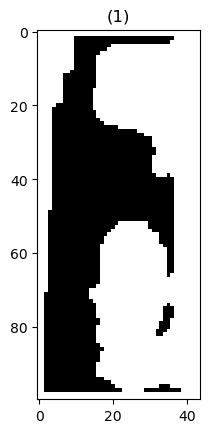

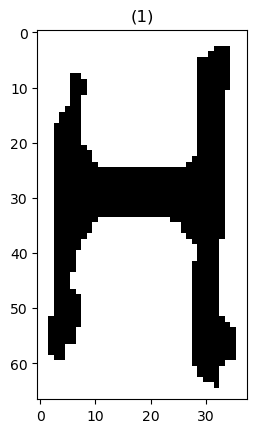

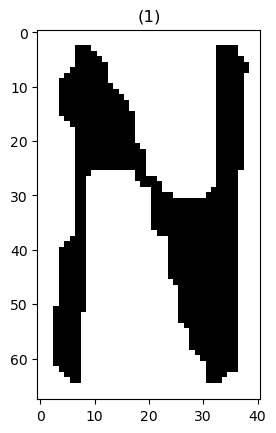

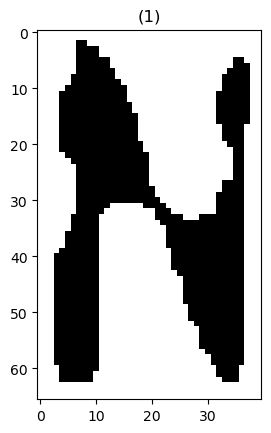

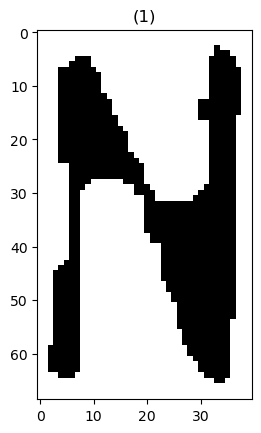

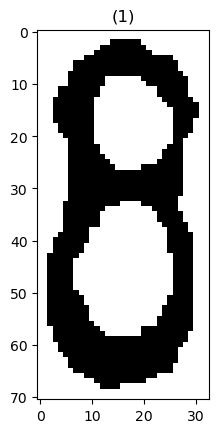

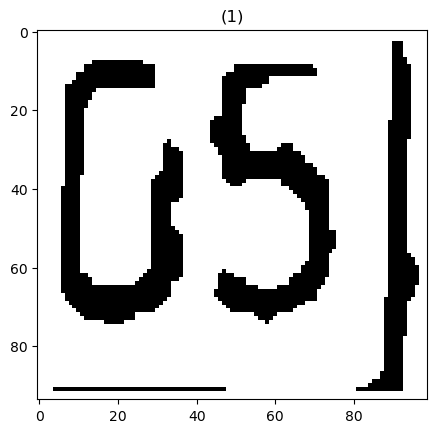

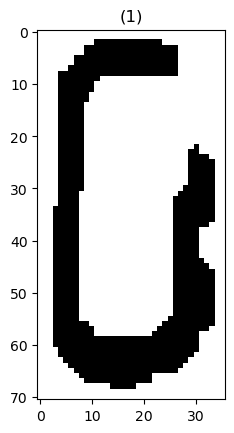

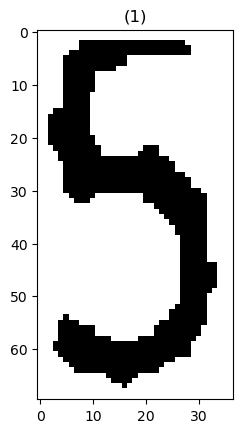

[array(['F'], dtype='<U1'), array(['H'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['N'], dtype='<U1'), array(['8'], dtype='<U1'), array(['U'], dtype='<U1'), array(['0'], dtype='<U1'), array(['5'], dtype='<U1')]
FHNNN8U05


In [10]:
def classifyChars(segmented):
    knn = classifiers['KNN']
    detected =[]
    for i, char_image in enumerate(segmented):
        features = extract_hog_features(char_image)
        detected.append(knn.predict([features]))
    
    return detected

image = cv2.imread('../trial-2/outputs/output-30.png')[:,:,1]
chars = classifyChars(segment_characters(image))
print(chars)
plateNumber = ''.join([item[0] for item in chars])
print(plateNumber)

In [11]:

# ALLOWED_CHARACTERS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
#     # Define kernel size for dilation and erosion
# kernel2 = np.ones((1, 2), np.uint8)  # You can adjust the size (3x3 is a typical choice)

# def preprocess_image(image):
#     # Resize the image to make characters larger if necessary
#     resized = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)

#     # Apply erosion (shrinks white regions)
#     eroded_image = cv2.erode(resized, kernel2, iterations=1)
#     return eroded_image

# def classify_characters_with_ocr(segmented_characters):
#     recognized_texts = []

#     # Loop through segmented characters and apply OCR
#     for i, char_image in enumerate(segmented_characters):
#         # Preprocess the character image
#         preprocessed_image = preprocess_image(char_image)
#         # Use Tesseract OCR to recognize the character
#         show_images([preprocessed_image])
#         text = pytesseract.image_to_string(preprocessed_image, config='--psm 10 --oem 3 -c tessedit_char_whitelist=' + ALLOWED_CHARACTERS)
#         if len(text) > 0:
#             # Take only the first valid character from the recognized text
#             text = text[0]

#         recognized_texts.append(text)

#     return recognized_texts

# recognized_texts = classify_characters_with_ocr(segmented_characters)

# # Print the recognized characters
# for i, text in enumerate(recognized_texts):
#     print(f"Character {i}: {text}")



In [12]:
import time

unordered_map = {}

# assume parking for 1 second = 15 pounds (hanghayyar el arqam di bas for testing purposes)

def calculate_fee(plate_number):
    current_time = time.time()  
    
    # Check if the string is already in the unordered map
    if plate_number in unordered_map:
        # Calculate the time difference
        saved_time = unordered_map.pop(plate_number)
        time_diff = current_time - saved_time
        print(f"Car with plate '{plate_number}'. exited after: {time_diff:.2f} seconds., Fee = {time_diff * 15:.2f}")
        return f"{time_diff * 15:.2f}"
    else:
        # Insert the string with the current time
        unordered_map[plate_number] = current_time
        print(f"Car with plate '{plate_number}' just entered the parking")
        return 0

In [13]:
from flask import Flask, request, jsonify
from flask_cors import CORS
import cv2
import pytesseract
import os
import threading

server_thread = None
stop_flag = threading.Event()

app = Flask("PlateDetect")
CORS(app)

@app.route('/extract_plate', methods=['POST'])
def extract_plate():
    try:
        image_file = request.files['image']
        image_path = "uploaded_image.jpg"
        image_file.save(image_path)
        print(image_file)
        # image = cv2.imread(image_path)
        # image = process_image(image)
        image = cv2.imread('../trial-2/outputs/output-4.png')[:,:,1] #TODO:replace with actual imag
        segmented_chars = segment_characters(image)
        classified = classifyChars(segmented_chars)
        plateNumber = ''.join([item[0] for item in classified])
        print(plateNumber)

        # Clean up
        os.remove(image_path)

        # Calculate fees
        fees = calculate_fee(plateNumber)
        return jsonify({"plate": plateNumber, "fees": fees})
    except Exception as e:
        return jsonify({"error": str(e)}), 500

@app.route('/train_model', methods=['POST'])
def train_model():
    run_experiment()
    return jsonify({"message": "Model training started."})

def run_flask():
    while not stop_flag.is_set():
        app.run(debug=False, use_reloader=False, port=5001)

server_thread = threading.Thread(target=run_flask)
server_thread.daemon = True
server_thread.start()

In [14]:
# if server_thread is not None:
#     stop_flag.set()  # Signal the thread to stop
#     server_thread.join()  # Wait for the thread to finish
#     print("Flask server stopped.")

Loading dataset...
Loaded 9153 images and 9153 labels.
Building model...


/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model...
Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 27s 109ms/step - accuracy: 0.0959 - loss: 3.3177 - val_accuracy: 0.5265 - val_loss: 1.9302
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 24s 105ms/step - accuracy: 0.5554 - loss: 1.6799 - val_accuracy: 0.7318 - val_loss: 0.9634
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 29s 128ms/step - accuracy: 0.7163 - loss: 1.0295 - val_accuracy: 0.7848 - val_loss: 0.7977
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.7664 - loss: 0.8334 - val_accuracy: 0.8034 - val_loss: 0.7293
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - accuracy: 0.8060 - loss: 0.6511 - val_accuracy: 0.8083 - val_loss: 0.6852
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - accuracy: 0.8293 - loss: 0.5882 - val_accuracy: 0.8192 - val_loss: 0.6550
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - accuracy: 0.8467 - loss: 0.5117 - val_accuracy: 0.8187 - val_loss: 0.6560
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 25s 108ms/step - accuracy

Test Accuracy: 82.85%
Model saved as chars74k_model.h5


Model loaded successfully!


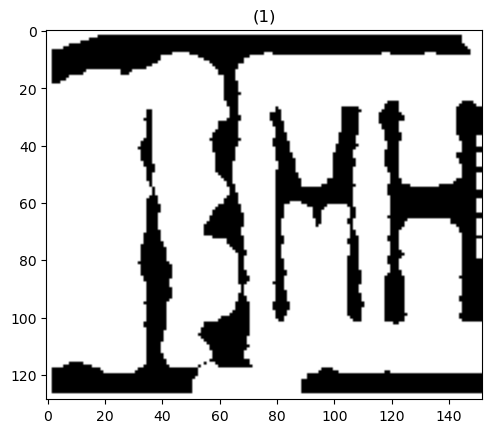

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


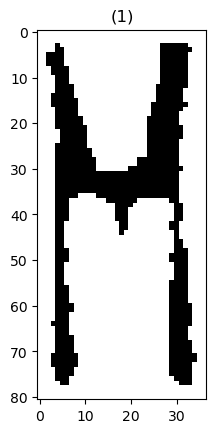

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


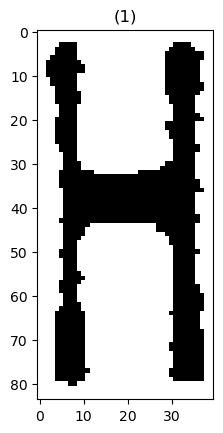

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


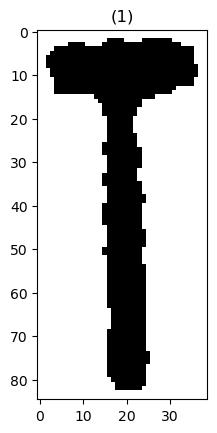

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


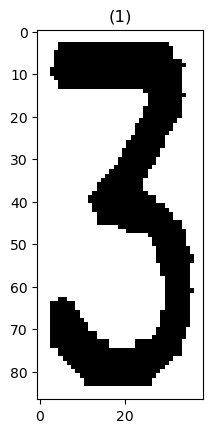

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


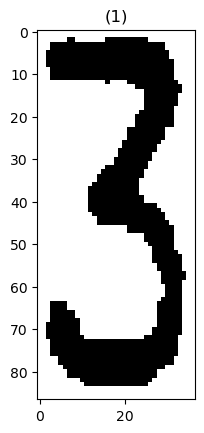

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


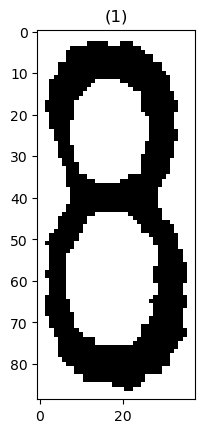

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


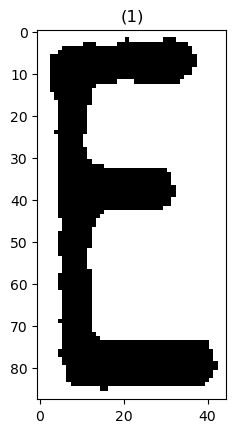

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted Label: EHHT558E


In [27]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

def preprocess_char_image(char_image):
    """Preprocess a segmented character image for prediction."""
    # Resize to the input size of the model
    char_image = cv2.resize(char_image, (64, 64))

    # Normalize pixel values
    char_image = char_image / 255.0

    # Add batch and channel dimensions
    char_image = char_image.reshape(1, 64, 64, 1)

    return char_image

def predictOCR(image):
    # Load the trained model
    model = load_model("chars74k_model.h5")
    print("Model loaded successfully!")

    # Segment the characters
    segmented_characters = segment_characters(image)

    # Initialize the predicted label
    predicted_label = ""

    # Iterate over each segmented character
    for i, char_image in enumerate(segmented_characters):
        # Preprocess the character image
        show_images([char_image])
        char_image = preprocess_char_image(char_image)
        # Predict the character
        predictions = model.predict(char_image)
        char_index = predictions.argmax()

        # Convert the character index to a label (e.g., digit or letter)
        if char_index < 10:
            predicted_label += str(char_index)  # 0-9
        else:
            predicted_label += chr(char_index - 10 + ord('A'))  # A-Z

    # Print the predicted label
    print(f"Predicted Label: {predicted_label}")

image = cv2.imread('../trial-2/outputs/output-3.png')[:,:,1]
predictOCR(image)
